# Classification of b-quark jets in the Aleph simulated data

Python macro for selecting b-jets in simulated (MC) Aleph Z->qqbar decays, using various methods:
* Initially, simply with "if"-statements making requirements on certain variables. This corresponds to selecting "boxes" in the input variable space (typically called "X"). One could also try a Fisher discriminant (linear combination of input variables), which corresponds to a plane in the X-space. But as the problem is non-linear, it is likely to be sub-optimal.

* Next using Machine Learning (ML) methods. We will try both tree based and Neural Net (NN) based methods, and see how complicated (or not) it is to get a good solution, and how much better it performs compared to the "classic" selection method.

In the end, this exercise is the simple start on moving into the territory of multidimensional analasis.

### Data:
The input variables (X) are:
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis.
* phi:    The azimuth angle of the jet. As the detector is uniform in phi, this should not matter (much).
* prob_b: Probability of being a b-jet from the pointing of the tracks to the vertex.
* spheri: Sphericity of the event, i.e. how spherical it is.
* pt2rel: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* multip: Multiplicity of the jet (in a relative measure).
* bqvjet: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* ptlrel: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).

The target variable (Y) is:
* isb:    1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net based classification variable (based on six input variables: prob_b, spheri, pt2rel, multip, bqvjet, and ptlrel), which you can compare to (and compete with, if you also only use these six variables):
* nnbjet: Value of original Aleph b-jet tagging algorithm (for reference).


### Task:
Thus, the task before you is to:<br>
1) Inspect the data and make sure that you understand what it (roughly) looks like, and<br>
2) Produce a function (first if-statements, then ML algorithm), which given the input variables X provides an output variable estimate, Y_est, which is "closest possible" to the target variable, Y. The "closest possible" is left to the user to define in a _Loss Function_, which we will discuss further. In classification problems (such as this), the typical loss function to use is "Binary Cross Entropy" (aka. LogLoss), see https://en.wikipedia.org/wiki/Cross_entropy.

***

* Author: Troels C. Petersen (NBI)
* Email:  petersen@nbi.dk
* Date:   20th of April 2021

In [ ]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
#from matplotlib import colors
#from matplotlib.colors import LogNorm
import numpy as np
import csv

Possible other packages to consider:
cornerplot, seaplot, sklearn.decomposition(PCA)

In [ ]:
r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

# Evaluate an attempt at classification:

This is made into a function, as this is called many times. It returns a "confusion matrix" and the fraction of wrong classifications.

In [ ]:
def evaluate(bquark) :
    N = [[0,0], [0,0]]   # Make a list of lists (i.e. matrix) for counting successes/failures.
    for i in np.arange(len(isb)):
        if (bquark[i] == 0 and isb[i] == 0) : N[0][0] += 1
        if (bquark[i] == 0 and isb[i] == 1) : N[0][1] += 1
        if (bquark[i] == 1 and isb[i] == 0) : N[1][0] += 1
        if (bquark[i] == 1 and isb[i] == 1) : N[1][1] += 1
    fracWrong = float(N[0][1]+N[1][0])/float(len(isb))
    return N, fracWrong

# Main program start:

In [ ]:
# Get data (with this very useful NumPy reader):
data = np.genfromtxt('AlephBtag_MC_small_v2.csv', names=True)

energy = data['energy']
cTheta = data['cTheta']
phi    = data['phi']
prob_b = data['prob_b']
spheri = data['spheri']
pt2rel = data['pt2rel']
multip = data['multip']
bqvjet = data['bqvjet']
ptlrel = data['ptlrel']
nnbjet = data['nnbjet']
isb    = data['isb']

print(f"  Total number of entries in data: {len(isb):7d}")

  Total number of entries in data:   33968


### Produce 1D figures:
Define the histogram range and binning (important - MatPlotLib is NOT good at this):

In [ ]:
Nbins = 100
xmin = 0.0
xmax = 1.0

### Make new lists selected based on what the jets really are (b-quark jet or light-quark jet):

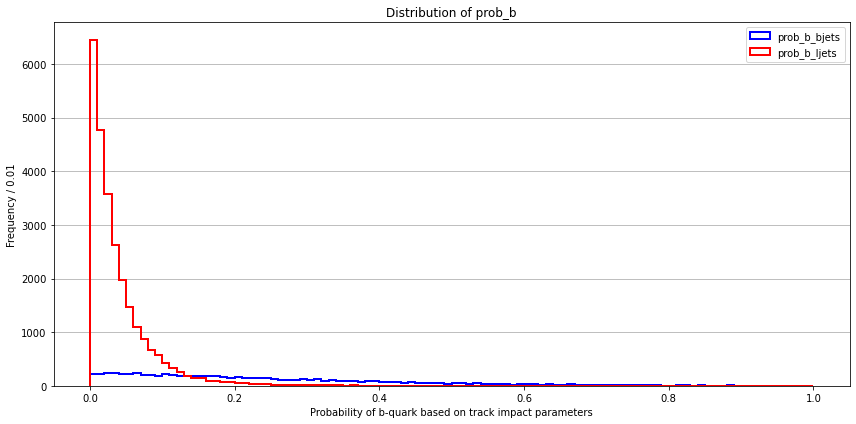

In [ ]:
prob_b_bjets = []
prob_b_ljets = []
bqvjet_bjets = []
bqvjet_ljets = []
for i in np.arange(len(isb)) :
    if (isb[i] == 1) :
        prob_b_bjets.append(prob_b[i])
        bqvjet_bjets.append(bqvjet[i])
    else             :
        prob_b_ljets.append(prob_b[i])
        bqvjet_ljets.append(bqvjet[i])

# Produce the actual figure, here with two histograms in it:
fig, ax = plt.subplots(figsize=(12, 6))      # Create just a single figure and axes (figsize is in inches!)
hist_prob_b_bjets = ax.hist(prob_b_bjets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_bjets', color='blue')
hist_prob_b_ljets = ax.hist(prob_b_ljets, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='prob_b_ljets', color='red')
ax.set_xlabel("Probability of b-quark based on track impact parameters")     # Label of x-axis
ax.set_ylabel("Frequency / 0.01")                                            # Label of y-axis
ax.set_title("Distribution of prob_b")                                       # Title of plot
ax.legend(loc='best')                                                        # Legend. Could also be 'upper right'
ax.grid(axis='y')
fig.tight_layout()

if SavePlots :
    fig.savefig('Hist_prob_b_and_bqvjet.pdf', dpi=600)

### Making my own figures

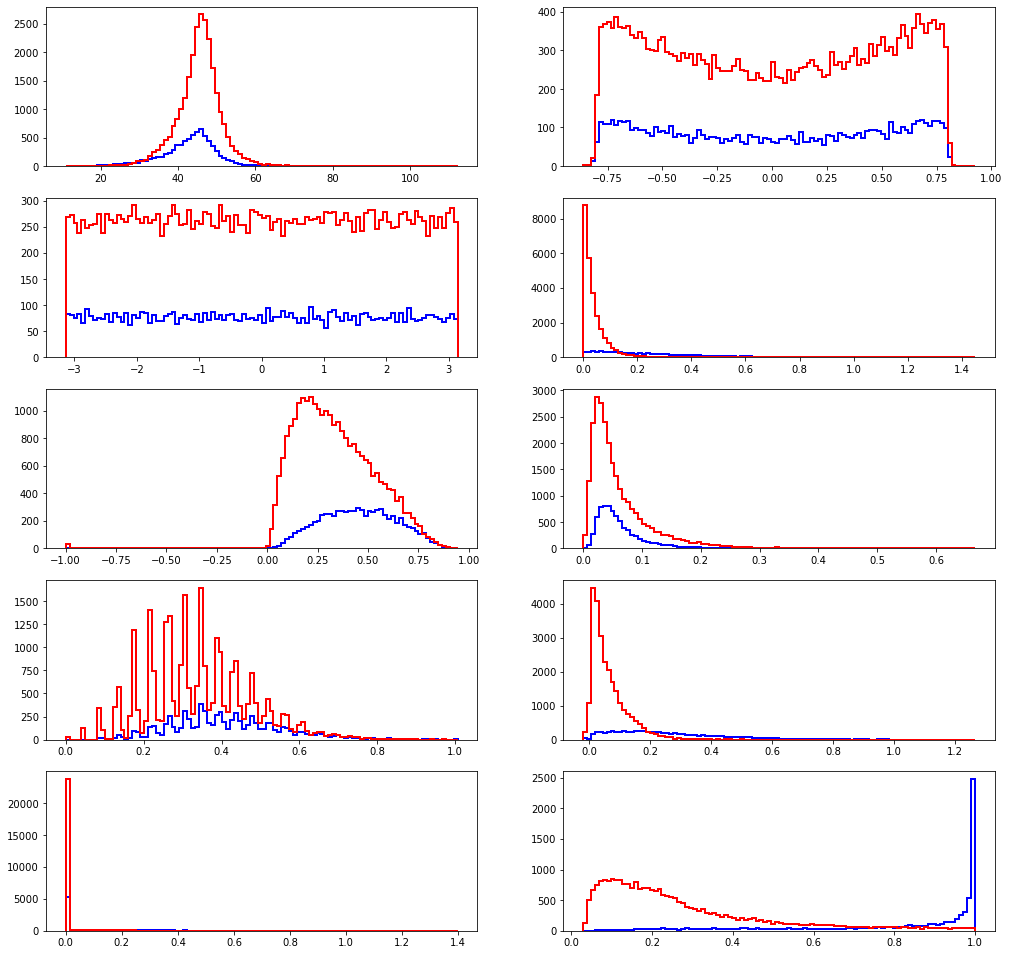

In [ ]:
# Lets show the distributions of all ten parameters

# Make a mask from isb
b_mask = (isb==1)

# List of parameters
parameters = [energy, cTheta, phi, prob_b, spheri, pt2rel, multip, bqvjet, ptlrel, nnbjet]

# Create figure
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(17,17))
ax = ax.flatten()

Nbins = 100

# Plot things in a for loop
for i in range(len(parameters)):
    
    xmin = np.min( parameters[i] )
    xmax = np.max( parameters[i] )
    
    ax[i].hist( parameters[i][b_mask], bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, color='blue')
    ax[i].hist( parameters[i][~b_mask], bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, color='red')

plt.show()

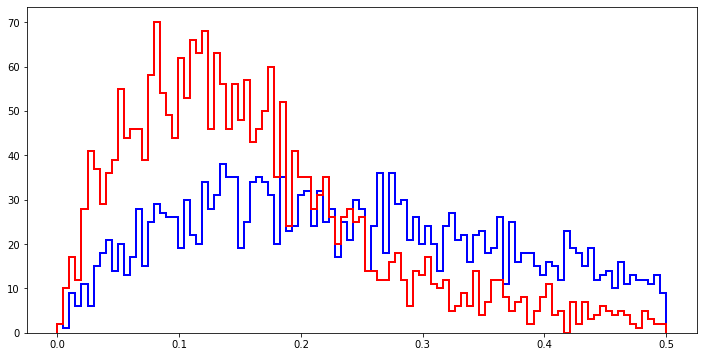

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
xmin, xmax = 0, 0.5
ax.hist( ptlrel[b_mask], bins=101, range=(xmin, xmax), histtype='step', linewidth=2, color='blue')
ax.hist( ptlrel[~b_mask], bins=101, range=(xmin, xmax), histtype='step', linewidth=2, color='red')
plt.show()

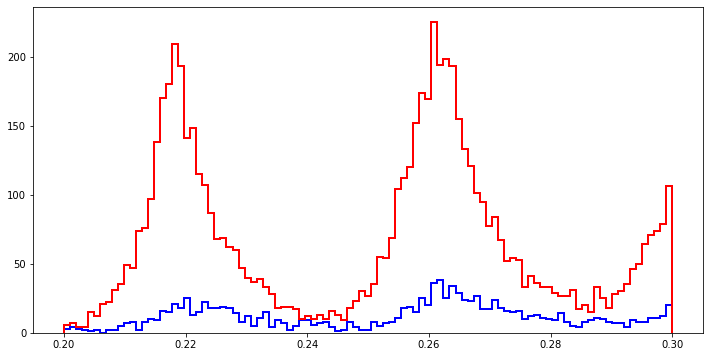

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
xmin, xmax = 0.2, 0.3
ax.hist( multip[b_mask], bins=101, range=(xmin, xmax), histtype='step', linewidth=2, color='blue')
ax.hist( multip[~b_mask], bins=101, range=(xmin, xmax), histtype='step', linewidth=2, color='red')
plt.show()


There doesnt seem to be some great separation in any of these.

### Produce 2D figures:

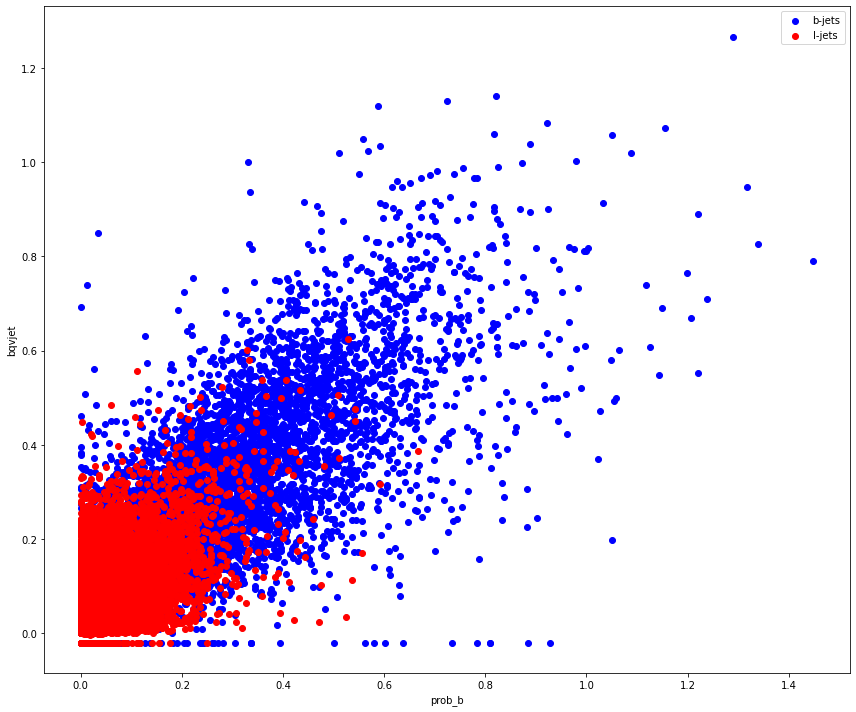

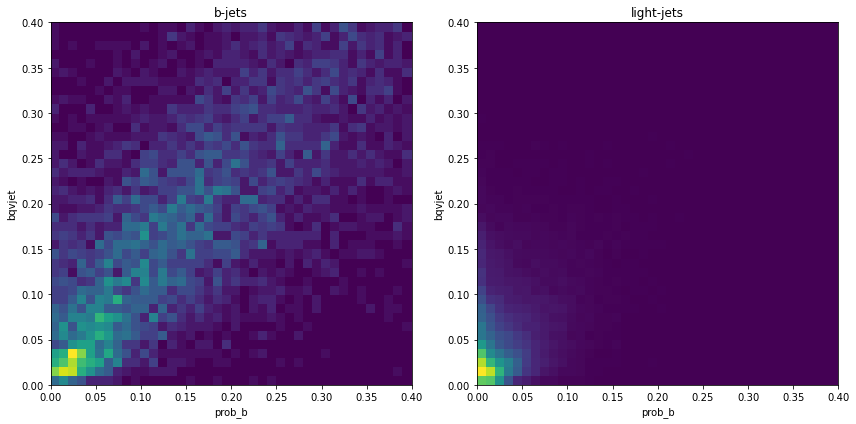

In [ ]:
# First we try a scatter plot, to see how the individual events distribute themselves:
fig2, ax2 = plt.subplots(figsize=(12, 10))
scat2_prob_b_vs_bqvjet_bjets = ax2.scatter(prob_b_bjets, bqvjet_bjets, label='b-jets', color='blue')
scat2_prob_b_vs_bqvjet_ljets = ax2.scatter(prob_b_ljets, bqvjet_ljets, label='l-jets', color='red')
ax2.set_xlabel('prob_b')
ax2.set_ylabel('bqvjet')
ax2.legend(loc='best')
fig2.tight_layout()

if SavePlots :
    fig2.savefig('Scatter_prob_b_vs_bqvjet.pdf', dpi=600)


# However, as can be seen in the figure, the overlap between b-jets and light-jets is large,
# and one covers much of the other in a scatter plot, which also does not show the amount of
# statistics in the dense regions. Therefore, we try two separate 2D histograms (zoomed):
fig3, ax3 = plt.subplots(1, 2, figsize=(12, 6))
hist2_prob_b_vs_bqvjet_bjets = ax3[0].hist2d(prob_b_bjets, bqvjet_bjets, bins=[40,40], range=[[0.0, 0.4], [0.0, 0.4]])
hist2_prob_b_vs_bqvjet_ljets = ax3[1].hist2d(prob_b_ljets, bqvjet_ljets, bins=[40,40], range=[[0.0, 0.4], [0.0, 0.4]])
ax3[0].set_title("b-jets")
ax3[0].set_xlabel('prob_b')
ax3[0].set_ylabel('bqvjet')
ax3[1].set_title("light-jets")
ax3[1].set_xlabel('prob_b')
ax3[1].set_ylabel('bqvjet')

fig3.tight_layout()

if SavePlots :
    fig3.savefig('Hist2D_prob_b_vs_bqvjet.pdf', dpi=600)

### Making my own figures

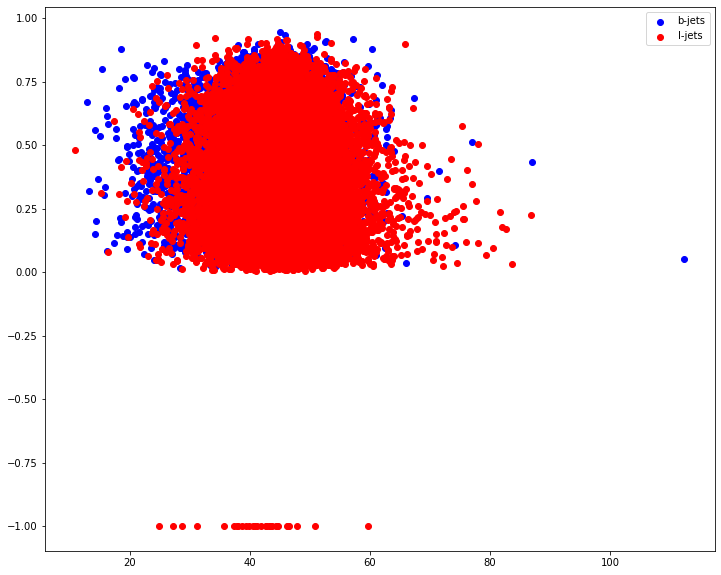

In [ ]:
# Firstwe try a scatter plot, to see how the individual events distribute themselves:
fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(energy[b_mask], spheri[b_mask], label='b-jets', color='blue')
ax.scatter(energy[~b_mask], spheri[~b_mask], label='l-jets', color='red')

ax.legend(loc='best')

This sucks

# Selection:

In [ ]:
loose_propb = 0.10
tight_propb = 0.16
loose_bqvjet = 0.12
tight_bqvjet = 0.28

In [ ]:
# I give the selection cuts names, so that they only need to be changed in ONE place (also ensures consistency!):
loose_propb = 0.12
tight_propb = 0.24

loose_bqvjet = 0.13
tight_bqvjet = 0.3

loose_spheri = 0.12
tight_spheri = 0.1

# If either of the variable clearly indicate b-quark, or of both loosely do so, call it a b-quark, otherwise not!
bquark=[]
for i in np.arange(len(prob_b)):
    
    if   (prob_b[i] > tight_propb)  :
        bquark.append(1)
        
    elif (bqvjet[i] > tight_bqvjet) :
        bquark.append(1)
        
    elif (spheri[i] < tight_spheri):
        bquark.append(0)
        
    elif ((prob_b[i] > loose_propb) and (bqvjet[i] > loose_bqvjet) and (spheri[i] > loose_spheri)) :
        bquark.append(1)
    else :
        bquark.append(0)

### Evaluate the selection:

In [ ]:
N, fracWrong = evaluate(bquark)
print("\nRESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:")
print("  First number in parenthesis is my estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong = ( (0,1) + (1,0) ) / sum = ", fracWrong)


RESULT OF HUMAN ATTEMPT AT A GOOD SELECTION:
  First number in parenthesis is my estimate, second is the MC truth:
  True-Negative (0,0)  =  25460
  False-Negative (0,1) =  2914
  False-Positive (1,0) =  848
  True-Positive (1,1)  =  4746
    Fraction wrong = ( (0,1) + (1,0) ) / sum =  0.11075129533678757


### Compare with NN-approach from 1990'ies:

In [ ]:
bquark=[]
for i in np.arange(len(prob_b)):
    if   (nnbjet[i] > 0.82) : bquark.append(1)
    else : bquark.append(0)

N, fracWrong = evaluate(bquark)
print("\nALEPH BJET TAG:")
print("  First number in parenthesis is NN estimate, second is the MC truth:")
print("  True-Negative (0,0)  = ", N[0][0])
print("  False-Negative (0,1) = ", N[0][1])
print("  False-Positive (1,0) = ", N[1][0])
print("  True-Positive (1,1)  = ", N[1][1])
print("    Fraction wrong = ( (0,1) + (1,0) ) / sum = ", fracWrong)


ALEPH BJET TAG:
  First number in parenthesis is NN estimate, second is the MC truth:
  True-Negative (0,0)  =  25464
  False-Negative (0,1) =  2519
  False-Positive (1,0) =  844
  True-Positive (1,1)  =  5141
    Fraction wrong = ( (0,1) + (1,0) ) / sum =  0.0990049458313707


# Classifying with XGBOOST (Tree-based)

In [ ]:
# Import packages
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import pandas as pd

Our (9) parameters are:
X=[energy, cTheta, phi, prob_b, spheri, pt2rel, multip, bqvjet, ptlrel] of shape (#quarks, #parameters) 

and their classification:
y = 0 or 1. 1 is a b-quark.


In [ ]:
# Split data set into parameters and label: X,y
X = np.column_stack( [energy, cTheta, phi, prob_b, spheri, pt2rel, multip, bqvjet, ptlrel] )
y = data['isb']

# Split data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Fit the model to the training data
model = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.01,
                            max_depth=10, eval_metric='logloss', n_estimators=300,
                            seed=42, use_label_encoder=False) #we use troels' parameters
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [ ]:
# make predictions on test data
y_pred = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.94%


In [ ]:
# Basically copying from TA
predictions = model.predict_proba(X_test) # find prediction that a particle belongs to each class ndarray

predictions = pd.DataFrame(predictions)
predictions.columns = ['not_bquark', 'bquark']
#predictions = (predictions['bquark'])/(predictions['bquark'] + predictions['not_bquark']) 
# ^^Last step not necessary we are dividing by one

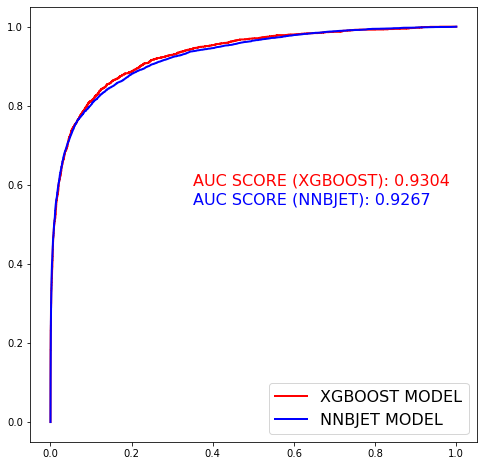

In [ ]:
# Find false and true positive rates for our model and 
fpr_XGB, tpr_XGB, _ = roc_curve(y_test, predictions['bquark'])
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(isb, nnbjet)

# Calculate AUC score (area under curve)
auc_score_XGB = auc(fpr_XGB, tpr_XGB)
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)

# Plot roc curves
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(fpr_XGB, tpr_XGB, label='XGBOOST MODEL', color='red', linewidth=2)
ax.plot(fpr_nnbjet, tpr_nnbjet, label='NNBJET MODEL', color='blue', linewidth=2)
ax.legend(prop={'size': 16})

# Mark auc scores
ax.text(0.35, 0.6, f'AUC SCORE (XGBOOST): {auc_score:.4f}', color='red', fontsize=16)
ax.text(0.35, 0.55, f'AUC SCORE (NNBJET): {auc_score_nnbjet:.4f}', color='blue', fontsize=16)

plt.show()

# Classifying with Neural Network

We will use the MLPClassifier. First we need to make our data tho, we will use the 6 parameters used in the nnbjet: prob_b, spheri, pt2rel, multip, bqvjet, ptlrel. And we will once again need to split data into training data and validation data.

Perhaps we should also scale our data, so they are similar, the parameters. We can do this later.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import QuantileTransformer

In [ ]:
# We create the parameter set: X and the labels y
X = np.column_stack( [prob_b, spheri, pt2rel, multip, bqvjet, ptlrel] )
y = data['isb']

# Scale the data to similar sizes (RobustScalar or QuantileTransformer)
qt = QuantileTransformer(n_quantiles=1000, random_state=0)
X_scaled = qt.fit_transform(X)

# Split data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

In [ ]:
# Fit the model to the training data
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=500)
model.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), max_iter=500,
              random_state=1, solver='lbfgs')

In [ ]:
# make predictions on test data
y_pred = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.39%


In [ ]:
# Basically copying from TA
predictions = model.predict_proba(X_test) # find prediction that a particle belongs to each class ndarray

predictions = pd.DataFrame(predictions)
predictions.columns = ['not_bquark', 'bquark']

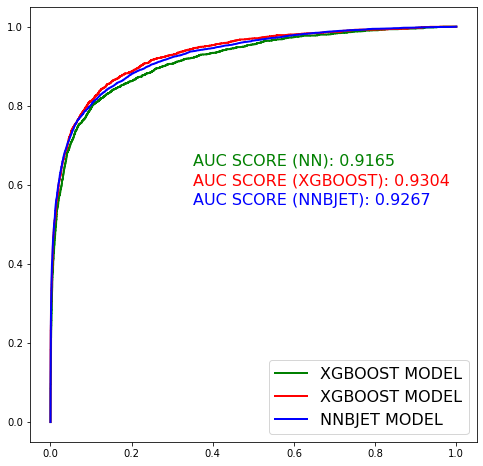

In [ ]:
# Find false and true positive rates for our model and 
fpr_NN, tpr_NN, _ = roc_curve(y_test, predictions['bquark'])

# Calculate AUC score (area under curve)
auc_score_NN = auc(fpr_NN, tpr_NN)

# Plot roc curves
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(fpr_NN, tpr_NN, label='XGBOOST MODEL', color='green', linewidth=2)
ax.plot(fpr_XGB, tpr_XGB, label='XGBOOST MODEL', color='red', linewidth=2)
ax.plot(fpr_nnbjet, tpr_nnbjet, label='NNBJET MODEL', color='blue', linewidth=2)
ax.legend(prop={'size': 16})

# Mark auc scores
ax.text(0.35, 0.65, f'AUC SCORE (NN): {auc_score_NN:.4f}', color='green', fontsize=16)
ax.text(0.35, 0.6, f'AUC SCORE (XGBOOST): {auc_score:.4f}', color='red', fontsize=16)
ax.text(0.35, 0.55, f'AUC SCORE (NNBJET): {auc_score_nnbjet:.4f}', color='blue', fontsize=16)

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=68e70cc0-4a2e-4baa-91ca-7b7df4c59022' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>